# Data & Apprentissage, M2CHPS

## 4th Lab Session

**Instructor:** [Argyris Kalogeratos](http://kalogeratos.com) (contact: argyris.kalogeratos@ens-paris-saclay.fr).  
**Sylabus:** [http://nvayatis.perso.math.cnrs.fr/CHPScourse.html](http://nvayatis.perso.math.cnrs.fr/CHPScourse.html)

The most updated version of this file can be found at instructor's webpage:  
[http://kalogeratos.com/MyCourses/DML-M2HPC/Lab#.ipynb](http://kalogeratos.com/psite/files/MyCourses/DML-M2HPC/Lab#.ipynb),
where '#' should be replaced by the number of the lab session. These notebooks are self-contained and hence have all the needed links to other resources.

Part of the scikit-learn material comes from its [online documentations and tutorial](https://scikit-learn.org/stable/modules/linear_model.html).

## 1. Fundamentals

**Clustering:** split the $N$ data points of a dataset in a number of ($k$) clusters, such that the elements of a cluster are highly related compared to elements of different clusters. 

Many variations of the problem:

* $k$ to be known or not
* hard or soft clustering (i.e. whether each datapoint is allowed to be part of only one cluster or not)
* parametric (e.g. probabilistic) and non-parametric methods
* density-based
* graph-based
* differences in terms of the algorithmic strategy that finds the clusters (e.g. hierarchical vs flat)
* ...

Finding clusters in point-clouds (eqv. communities in graphs) is a challenging problem:

* No concensus on the definition of « what is a cluster ».
* NP-hard problem: i.e. there are combinatorics behind separating optimally subsets of vertices and the problem cannot be solved in polynomial time.
* Lack of ground truth in real situations to validate results.

Result of great interest for a plethora of reasons:

* Understanding data
* Visualization
* Compression
* …

## 2. [Hierarchical Agglomerative Clustering](https://scikit-learn.org/stable/auto_examples/cluster/plot_linkage_comparison.html#sphx-glr-auto-examples-cluster-plot-linkage-comparison-py) 

Hierarchcal clustering is an approach (usually greedy) that successively changes the solution

* **Agglomerative** is merging groups (bottom up)
* **Divisive** is splitting groups

Hierarchical clustering returns a dendrogram with all the hierarchical structure. Cutting the hierarchy at any level 𝛾 (from the top) gives 𝛾+1 clusters

At each step the change should minimize a cost function measuring the dissimilarity between the datapoints in each group. Many options: a simple one is just the Euclidean or Manhattan.

**Hierarchical Agglomerative Clustering** (bottom up)
 1. Choose dissimilarity metric between groups ( !! )
 
 2. Assign each vertex to its own singleton group (1 vertex per group)
 
 3. Merge the two groups with the smallest dissimilarity
 
 4. Compute the dissimilarity of the new group with the preexisting ones
 
 5. If the current number of groups > 1 … goto (3)

The most critical part is to define group similarity! This are called **linkage methods**.

<img src="linkage.png" alt="Drawing" style="width: 600px;"/>

The main linkage methods are:

* **single linkage** is the minimum distance between objects of the two clusters. This is is fast, and can perform well on non-globular data, but it performs poorly in the presence of noise.
* **average linkage** is the average distance between objects of the two clusters.
* **complete linkage** is the maximum distance between objects of the two clusters. Both this one and the previous one perform well on cleanly separated globular clusters, but have mixed results otherwise.
* **Ward** merges clusters that lead to the minimal increase in the variance. This is the most effective method for noisy data.
* **Centroid-based** merges clusters with the closest centroids. Also a fast approach.
* ...

<img src="linkage2.png" alt="Drawing" style="width: 800px;"/>

<img src="hierarchy-cut.png" alt="Drawing" style="width: 600px;"/>

For some quality measure $Q$ (this is to be defined by the expert) we could decide to cut the hierarchy at some level and produce the indicated clusters.

The computational cost of HAC, when fully deployed, is of the order $O(n^3)$, however its  benefit is the fact that it provides the full cluster hierarchy and not just a flat clustering. 

### Numerical demonstration

This demonstration shows characteristics of different *linkage methods* for [hierarchical clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering) on 2D datasets of different types. 

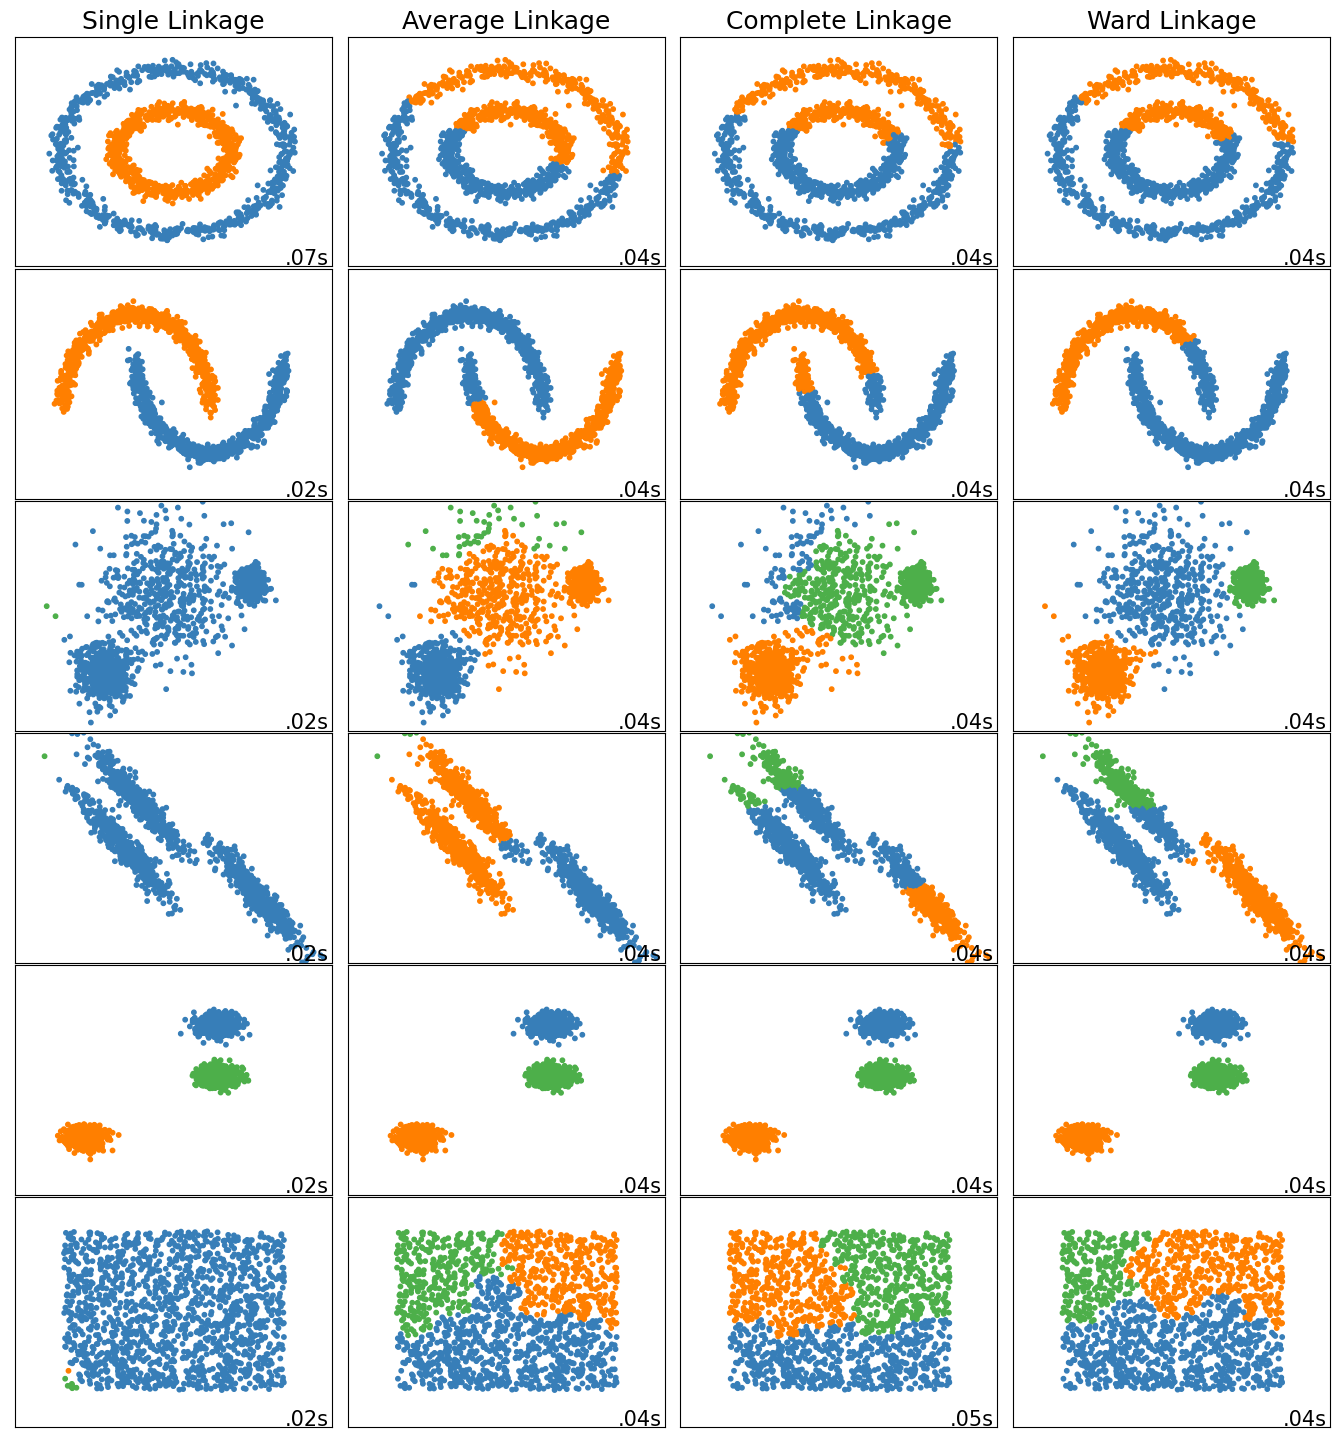

In [1]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# Generate samples
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# Set up cluster parameters
plt.figure(figsize=(9 * 1.3 + 2, 14.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'n_neighbors': 10, 'n_clusters': 3}

datasets = [
    (noisy_circles, {'n_clusters': 2}),
    (noisy_moons, {'n_clusters': 2}),
    (varied, {'n_neighbors': 2}),
    (aniso, {'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # ============
    # Create cluster objects
    # ============
    ward = cluster.AgglomerativeClustering(n_clusters=params['n_clusters'], linkage='ward')
    complete = cluster.AgglomerativeClustering(n_clusters=params['n_clusters'], linkage='complete')
    average = cluster.AgglomerativeClustering(n_clusters=params['n_clusters'], linkage='average')
    single = cluster.AgglomerativeClustering(n_clusters=params['n_clusters'], linkage='single')

    clustering_algorithms = (
        ('Single Linkage', single),
        ('Average Linkage', average),
        ('Complete Linkage', complete),
        ('Ward Linkage', ward)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()


## 3. [Mean-shift Clustering](https://scikit-learn.org/stable/auto_examples/cluster/plot_mean_shift.html#sphx-glr-auto-examples-cluster-plot-mean-shift-py)

[Mean-shift](https://en.wikipedia.org/wiki/Mean_shift) is a non-parametric clustering algorithm. Intuitively, it is a mode-seeking algorithm, in the sense that it tries to place the center of a cluster at a mode of the data density (a place where the density is maximized). 

The algorithm picks a starting point in the dataspace, then using a *kernel* it spots the closest points to the starting point and weights them accordingly. These weighted closest points form the new center of the clsuter.

This method repeats the above several times and filters out near-dublicate clusters. Special methods should be used for *kernel bandwidth estimation* (i.e. how wide the kernel will be) and seed selection at "interesting" points.

number of estimated clusters : 3


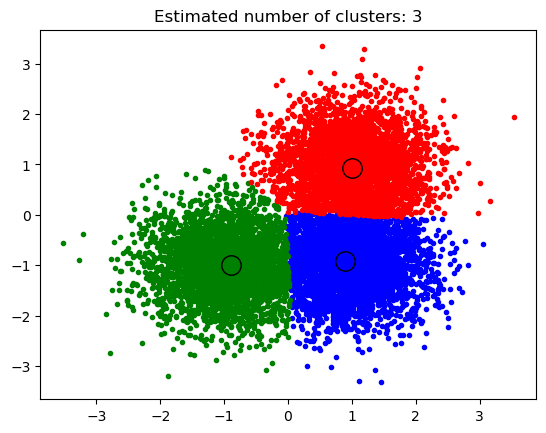

In [2]:
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs

# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, _ = make_blobs(n_samples=10000, centers=centers, cluster_std=0.6)

###### Compute clustering with MeanShift

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

## 4. [$k$-means Clustering](https://en.wikipedia.org/wiki/K-means_clustering)

$k$-means is the most popular clustering algorithm, due to its simplicity and its fast implementation. It requires the number of clusters $k$ as input. Then it starts from $k$ initial points (there are many ways to initialize them) and iteratively it improves the result.

The two steps it performs are:

* Assigns the data objects to the cluster with the closest centroid. 
* Updates the cluster centroids by computing the average of all objects in a cluster.

What this algorithm minimizes is the within cluster sum of square error (SSE).


### 4.1. [Demonstration of k-means assumptions](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html#sphx-glr-auto-examples-cluster-plot-kmeans-assumptions-py)


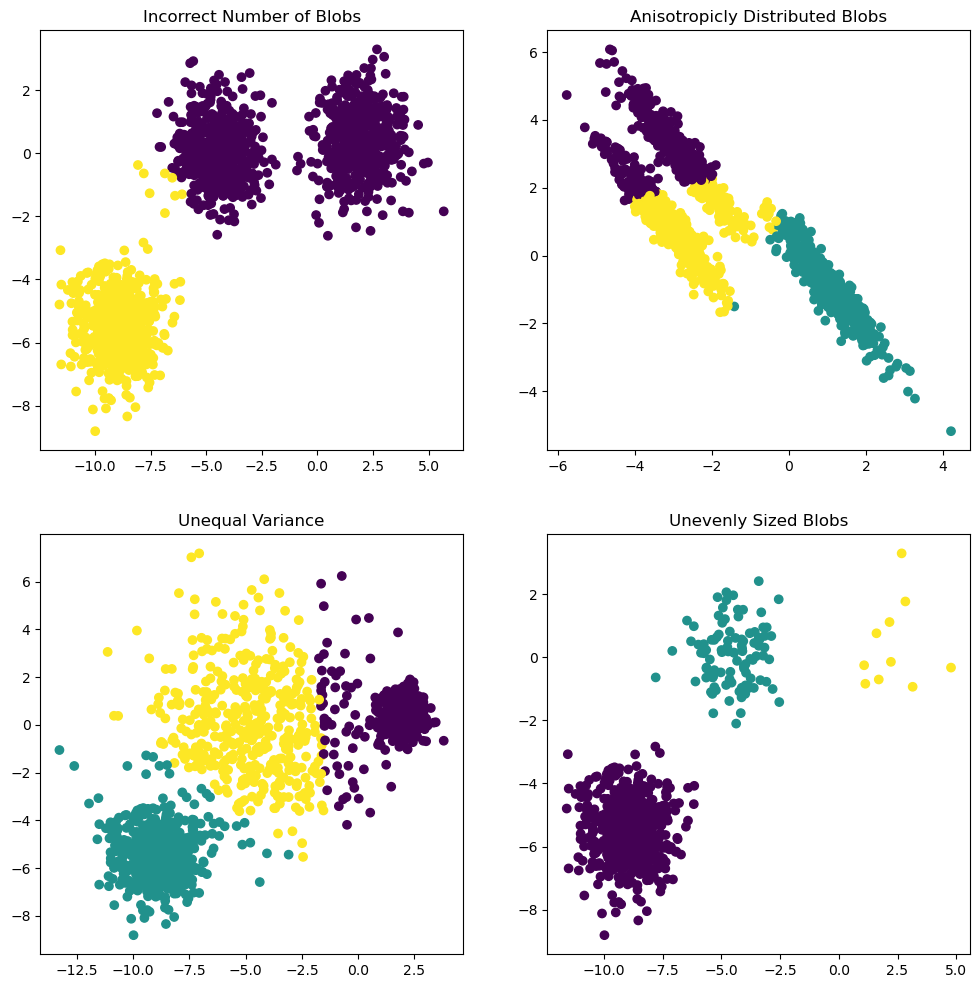

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.figure(figsize=(12, 12))

n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

# Incorrect number of clusters
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)

plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Incorrect Number of Blobs")

# Anisotropicly distributed data
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_aniso)

plt.subplot(222)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
plt.title("Anisotropicly Distributed Blobs")

# Different variance
X_varied, y_varied = make_blobs(n_samples=n_samples,
                                cluster_std=[1.0, 2.5, 0.5],
                                random_state=random_state)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_varied)

plt.subplot(223)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
plt.title("Unequal Variance")

# Unevenly sized blobs
X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
y_pred = KMeans(n_clusters=3,
                random_state=random_state).fit_predict(X_filtered)

plt.subplot(224)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
plt.title("Unevenly Sized Blobs")

plt.show()

### 4.2. [$k$-means Initialization](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_stability_low_dim_dense.html#sphx-glr-auto-examples-cluster-plot-kmeans-stability-low-dim-dense-py)

The first plot shows the best within-cluster sum of squared errors (SSE or inertia) reached for each combination of the model (KMeans or MiniBatchKMeans, which uses just a different subsample of the data to perform each time the two steps: data assignment to clusters and then cluster centers' update) and the init method (``init="random"`` or ``init="kmeans++"``, which starts from one random data point as first cluster center and each next center is put to other points selected according to the with probability proposrtional to the distance to the existing cluster centers) for increasing values of the ``n_init`` parameter that controls the number of initializations.

The second plot demonstrate one single run of the ``MiniBatchKMeans`` estimator using a ``init="random"`` and ``n_init=1``. This run leads to a bad convergence (local optimum) with estimated centers stuck between ground truth clusters.

The dataset used for evaluation is a 2D grid of isotropic Gaussian clusters widely spaced.

Evaluation of KMeans with k-means++ init
Evaluation of KMeans with random init
Evaluation of MiniBatchKMeans with k-means++ init
Evaluation of MiniBatchKMeans with random init


/var/folders/gx/nw4hqqyj5yx8dt594_ys11nc0000gn/T/ipykernel_10688/2399535026.py:84: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(X[my_members, 0], X[my_members, 1], 'o', marker='.', c=color)


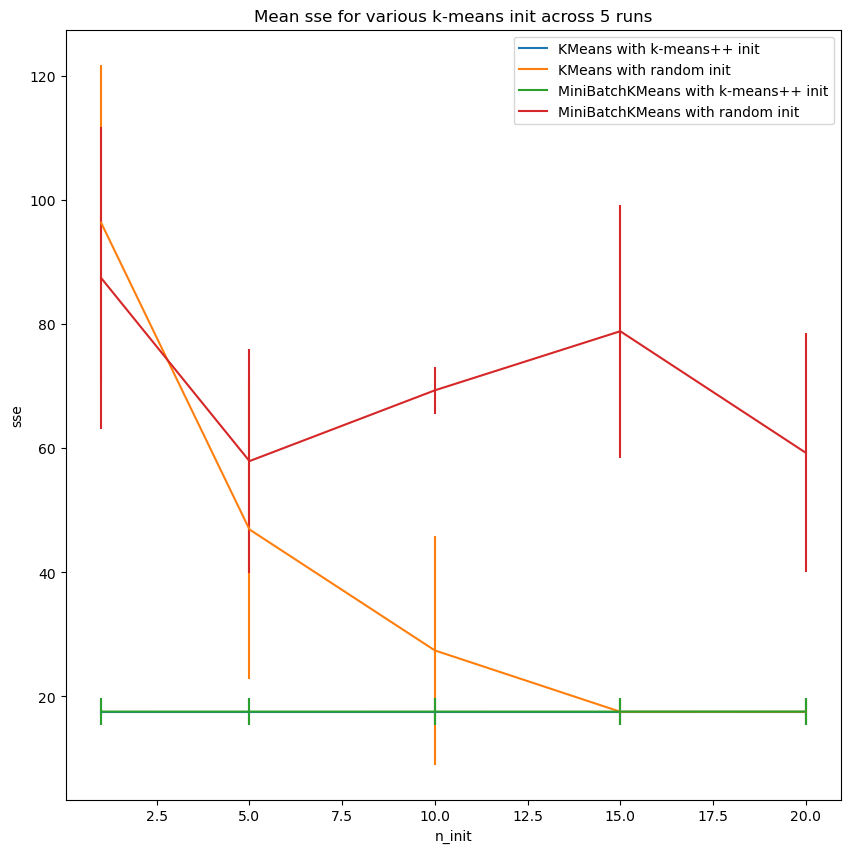

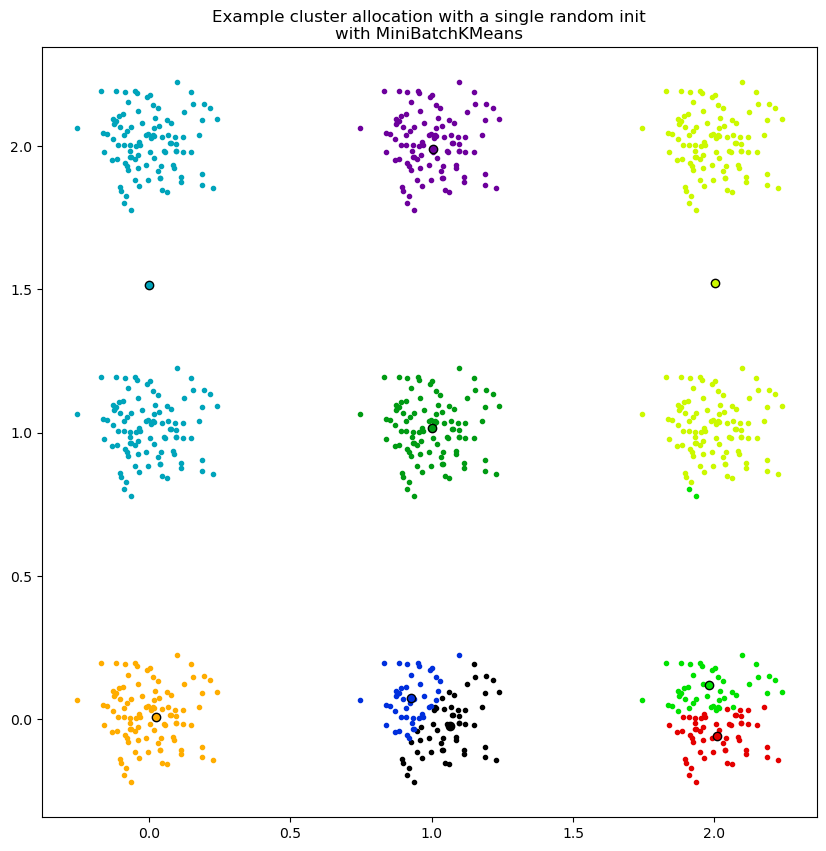

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.utils import shuffle
from sklearn.utils import check_random_state
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

random_state = np.random.RandomState(0)

# Number of run (with randomly generated dataset) for each strategy so as
# to be able to compute an estimate of the standard deviation
n_runs = 5

# k-means models can do several random inits so as to be able to trade
# CPU time for convergence robustness
n_init_range = np.array([1, 5, 10, 15, 20])

# Datasets generation parameters
n_samples_per_center = 100
grid_size = 3
scale = 0.1
n_clusters = grid_size ** 2


def make_data(random_state, n_samples_per_center, grid_size, scale):
    random_state = check_random_state(random_state)
    centers = np.array([[i, j]
                        for i in range(grid_size)
                        for j in range(grid_size)])
    n_clusters_true, n_features = centers.shape

    noise = random_state.normal(
        scale=scale, size=(n_samples_per_center, centers.shape[1]))

    X = np.concatenate([c + noise for c in centers])
    y = np.concatenate([[i] * n_samples_per_center
                        for i in range(n_clusters_true)])
    return shuffle(X, y, random_state=random_state)

# Part 1: Quantitative evaluation of various init methods

plt.figure(figsize=(10, 10))
plots = []
legends = []

cases = [
    (KMeans, 'k-means++', {}),
    (KMeans, 'random', {}),
    (MiniBatchKMeans, 'k-means++', {'max_no_improvement': 3}),
    (MiniBatchKMeans, 'random', {'max_no_improvement': 3, 'init_size': 500}),
]

for factory, init, params in cases:
    print("Evaluation of %s with %s init" % (factory.__name__, init))
    sse = np.empty((len(n_init_range), n_runs))

    for run_id in range(n_runs):
        X, y = make_data(run_id, n_samples_per_center, grid_size, scale)
        for i, n_init in enumerate(n_init_range):
            km = factory(n_clusters=n_clusters, init=init, random_state=run_id,
                         n_init=n_init, **params).fit(X)
            sse[i, run_id] = km.inertia_
    p = plt.errorbar(n_init_range, sse.mean(axis=1), sse.std(axis=1))
    plots.append(p[0])
    legends.append("%s with %s init" % (factory.__name__, init))

plt.xlabel('n_init')
plt.ylabel('sse')
plt.legend(plots, legends)
plt.title("Mean sse for various k-means init across %d runs" % n_runs)

# Part 2: Qualitative visual inspection of the convergence

X, y = make_data(random_state, n_samples_per_center, grid_size, scale)
km = MiniBatchKMeans(n_clusters=n_clusters, init='random', n_init=1,
                     random_state=random_state).fit(X)

plt.figure(figsize=(10, 10))
for k in range(n_clusters):
    my_members = km.labels_ == k
    color = cm.nipy_spectral(float(k) / n_clusters, 1)
    plt.plot(X[my_members, 0], X[my_members, 1], 'o', marker='.', c=color)
    cluster_center = km.cluster_centers_[k]
    plt.plot(cluster_center[0], cluster_center[1], 'o',
             markerfacecolor=color, markeredgecolor='k', markersize=6)
    plt.title("Example cluster allocation with a single random init\n"
              "with MiniBatchKMeans")

plt.show()

### 4.3. Application: Color quantization in images

**Color quantization** is the impage processing task that tries to optimally reduce the number of different colors used when storing and rendering an image. This task can be performed through data clustering of the pixel color values. In essence, this is a process that compresses the image.

Fitting model on a small sub-sample of the data
done in 0.101s.
Predicting color indices on the full image (k-means)
done in 0.094s.
Predicting color indices on the full image (random)
done in 0.165s.


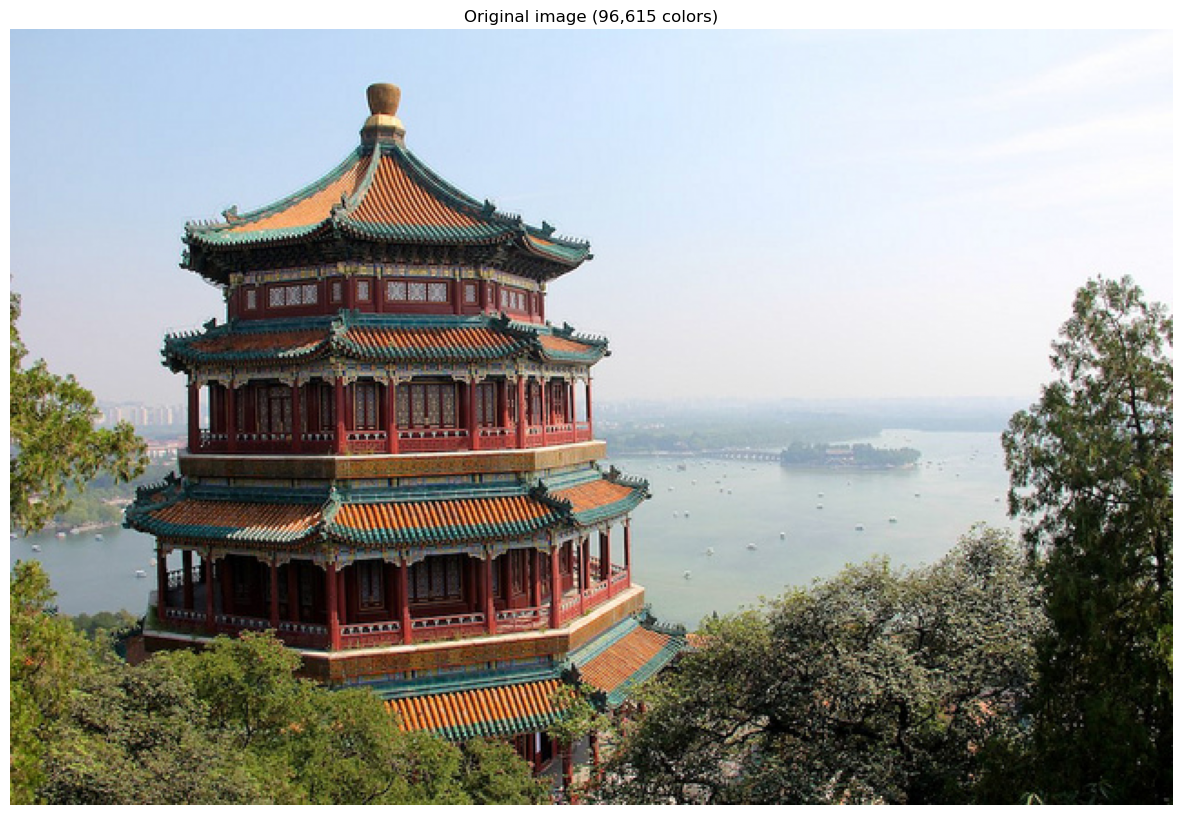

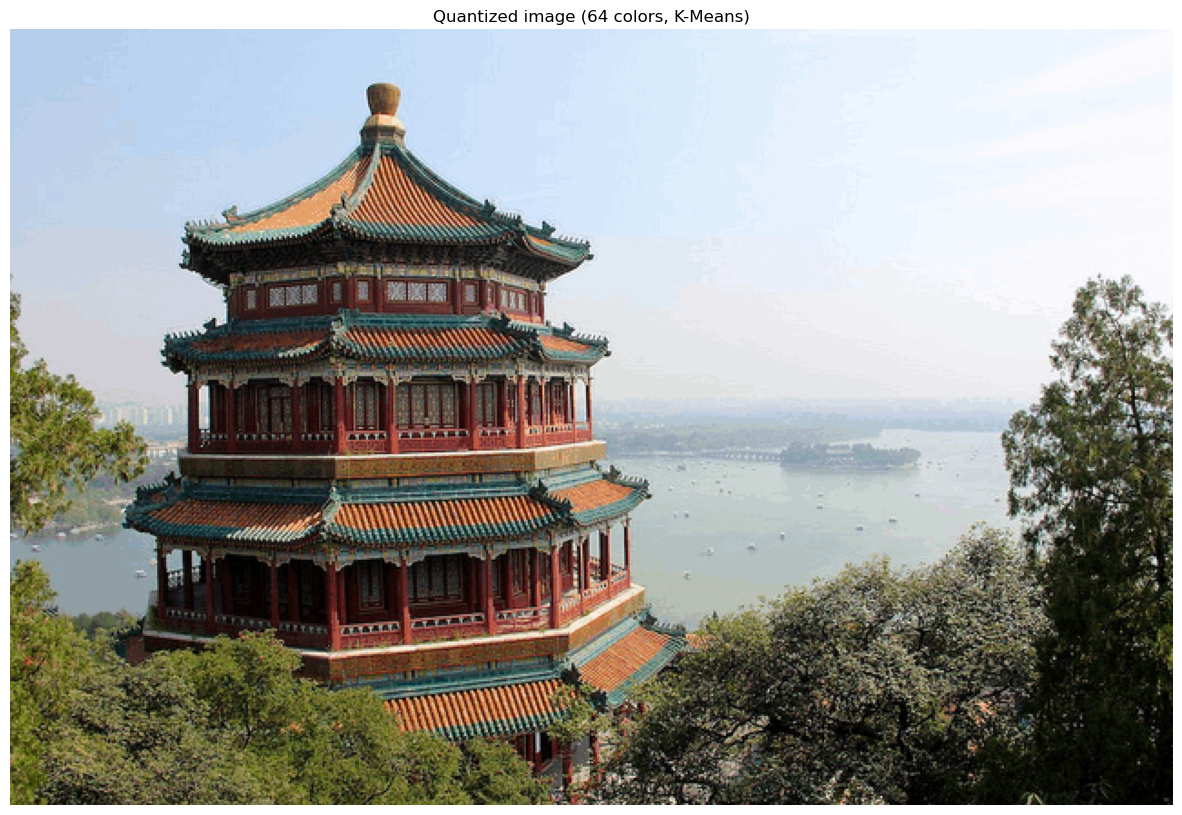

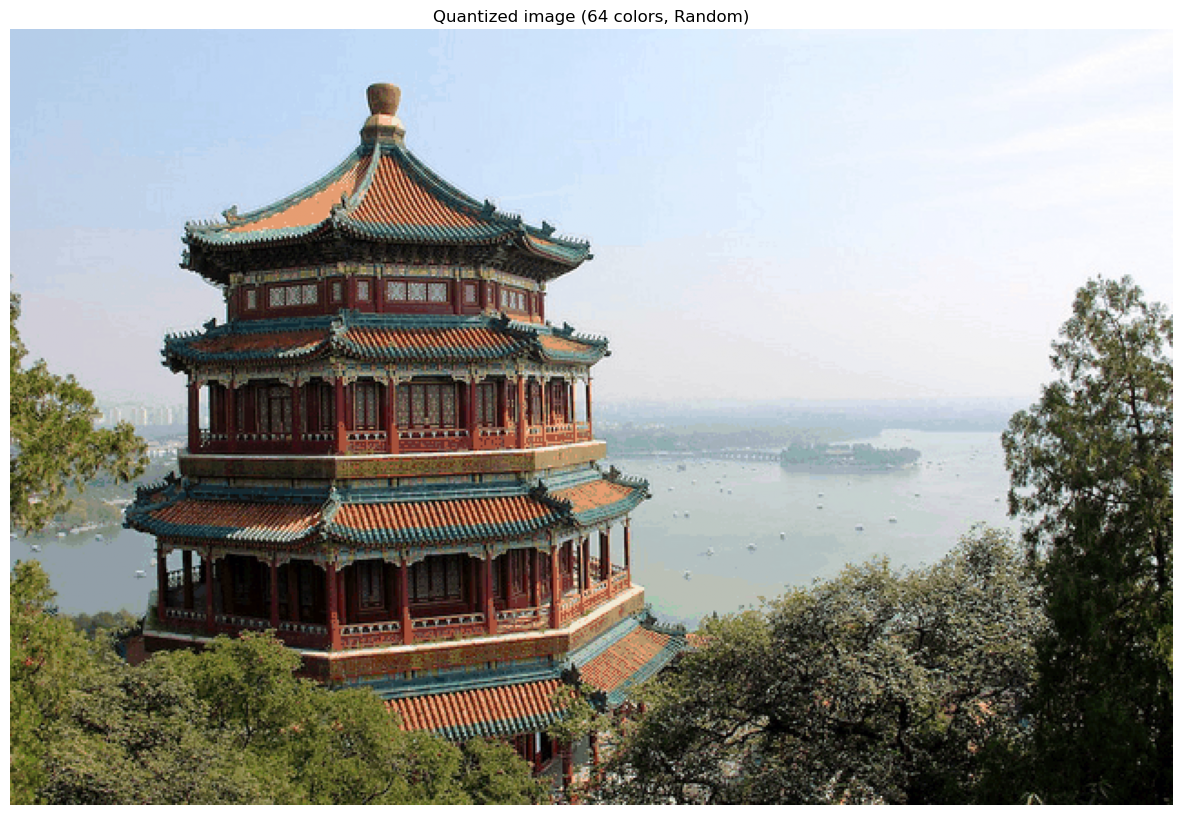

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time

n_colors = 256

# Load the Summer Palace photo
china = load_sample_image("china.jpg")

# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves works well on float data (need to
# be in the range [0-1])
china = np.array(china, dtype=np.float64) / 255

# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(china.shape)
assert d == 3
image_array = np.reshape(china, (w * h, d))

print("Fitting model on a small sub-sample of the data")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
print("done in %0.3fs." % (time() - t0))

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array)
print("done in %0.3fs." % (time() - t0))


codebook_random = shuffle(image_array, random_state=0)[:n_colors]
print("Predicting color indices on the full image (random)")
t0 = time()
labels_random = pairwise_distances_argmin(codebook_random,
                                          image_array,
                                          axis=0)
print("done in %0.3fs." % (time() - t0))


def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

# Display all results, alongside original image
plt.figure(figsize=(15, 15))
plt.clf()
plt.axis('off')
plt.title('Original image (96,615 colors)')
plt.imshow(china)

plt.figure(figsize=(15, 15))
plt.clf()
plt.axis('off')
plt.title('Quantized image (64 colors, K-Means)')
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

plt.figure(figsize=(15, 15))
plt.clf()
plt.axis('off')
plt.title('Quantized image (64 colors, Random)')
plt.imshow(recreate_image(codebook_random, labels_random, w, h))
plt.show()

## 5. Gaussian Mixure Model

The ``GaussianMixture`` object implements the [Expectation-Maximization](https://scikit-learn.org/stable/modules/mixture.html#expectation-maximization) (EM) algorithm for fitting mixture-of-Gaussian models. It can also draw confidence ellipsoids for multivariate models, and compute the Bayesian Information Criterion to assess the number of clusters in the data. A ``GaussianMixture.fit`` method is provided that learns a Gaussian Mixture Model from train data. Given test data, it can assign to each sample the Gaussian it mostly probably belong to using the ``GaussianMixture.predict`` method.

The ``GaussianMixture`` comes with different options to constrain the covariance of the difference classes estimated: spherical, diagonal, tied or full covariance.

TypeError: Ellipse.__init__() takes 4 positional arguments but 5 were given

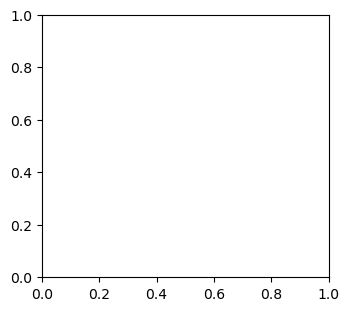

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

colors = ['navy', 'turquoise', 'darkorange']

def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

iris = datasets.load_iris()

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))


X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {cov_type: GaussianMixture(n_components=n_classes,
              covariance_type=cov_type, max_iter=20, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=iris.target_names[n])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))


plt.show()

## 6. [DBSCAN](https://scikit-learn.org/stable/auto_examples/cluster/plot_optics.html#sphx-glr-auto-examples-cluster-plot-optics-py)

DBSCAN, on the other end, works in a completely different way. Specifically, it is one of the most popular density-based methods. It starts from an arbitrary *core point* of high-density assuming that a cluster starts from that point, and then expands the cluster to other points close to the existing in the cluster. When not able to expand further, then it considers the set found as a cluster and restarts the process from a different core point which is not part of the so far found clusters.

The OPTICS method is a DBSCAN variation proposed for datasets with variable density. 

DBSCAN-like methods involve several thresholds to achieve their ends, which can be tricky to tune in practice. Most important one is the $eps$ distance threshold lower to which two points are considered neighbors. The other important parameter is the number of neighbors a point should have to be considered a core point. The general principle is that if a point $p$ is in closer distance to $q$ than $eps$, then $p$ is *directly reachable* by $q$. At the same time, if there is a path from $p$ through $q$ ... $s$ ... $t$, where all pairwise distances between subsequent points of the path are all shorter than $eps$, then $p$ is (simply, but not directly) *reachable* by $t$.

Since it is based on density and similarity/distance calculations, they are quite computationally costly (computing neighborhoods) and sensitive to high-dimensional settings. 

What follows is a short demo comparing an implementation very close to the original DBSCAN and the variation OPTICS.


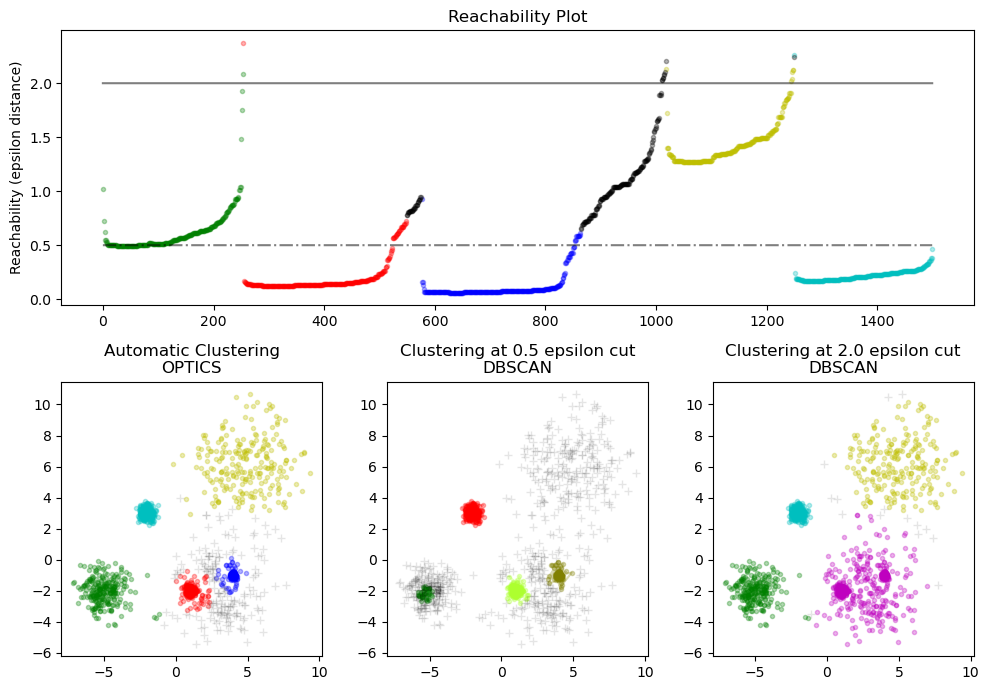

In [10]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data

np.random.seed(0)
n_points_per_cluster = 250

C1 = [-5, -2] + .8 * np.random.randn(n_points_per_cluster, 2)
C2 = [4, -1] + .1 * np.random.randn(n_points_per_cluster, 2)
C3 = [1, -2] + .2 * np.random.randn(n_points_per_cluster, 2)
C4 = [-2, 3] + .3 * np.random.randn(n_points_per_cluster, 2)
C5 = [3, -2] + 1.6 * np.random.randn(n_points_per_cluster, 2)
C6 = [5, 6] + 2 * np.random.randn(n_points_per_cluster, 2)
X = np.vstack((C1, C2, C3, C4, C5, C6))

clust = OPTICS(min_samples=50, xi=.05, min_cluster_size=.05)

# Run the fit
clust.fit(X)

labels_050 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=0.5)
labels_200 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=2)

space = np.arange(len(X))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
ax1.plot(space, np.full_like(space, 2., dtype=float), 'k-', alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), 'k-.', alpha=0.5)
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')

# OPTICS
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    Xk = X[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax2.set_title('Automatic Clustering\nOPTICS')

# DBSCAN at 0.5
colors = ['g', 'greenyellow', 'olive', 'r', 'b', 'c']
for klass, color in zip(range(0, 6), colors):
    Xk = X[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3, marker='.')
ax3.plot(X[labels_050 == -1, 0], X[labels_050 == -1, 1], 'k+', alpha=0.1)
ax3.set_title('Clustering at 0.5 epsilon cut\nDBSCAN')

# DBSCAN at 2.
colors = ['g.', 'm.', 'y.', 'c.']
for klass, color in zip(range(0, 4), colors):
    Xk = X[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(X[labels_200 == -1, 0], X[labels_200 == -1, 1], 'k+', alpha=0.1)
ax4.set_title('Clustering at 2.0 epsilon cut\nDBSCAN')

plt.tight_layout()
plt.show()

## 7. [Spectral Clustering (graph-based)](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html)

### Fundamentals for graph-based clustering methods

First thing first: to apply a graph-based method one needs to define a graph for a given problem?

* **Case A:** the graph is given (graph or a matrix for relational data)
    - Use it as is
    - `correct’ / `improve’ the input graph
* **Case B:** for native network problems, network modeling can define a problem-specific graph
* **Case C:** infer it from the data
- **Case C.a:** for a point-cloud, any sort of similarity matrix can serve the role of a graphUsefull tools to make a sparse graph:
    - k-Nearest Neighbors
    - kernelized similarities (e.g. via a Gaussian kernel)
    - value thresholding (setting to zero the low similarity values)
    - Case C.b: infer it from more complicated data, such as signals
    
<img src="make-point-cloud.png" alt="Drawing" style="width: 600px;"/>


### Spectral Clustering 

* Considers a Similarity function (called *kernel function*) to compute a $n$x$n$ *affinity matrix* $A$ containing all the pairwise similarities between any two data points. Typical kernel is the Gaussian kernel (also mentioned as RBF) which uses the Euclidean distances $d(x_i,x_j)$ of two data points: $\exp(-\gamma \cdot d(x_i,x_j)^2)$.
* On this matrix, it may zero down all similarities but a small number of -let's say- $Κ$NNs (nearest neighbors) for each data point.
* And finally computes the Laplacian matrix $L = D - A$, where $D$ is a diagonal matrix with the row-wise sum of $A$. This is the typical Laplacian matrix, but other variants exist.
* Then, it uses Singular Value Decomposition (SVD) to project the data using the eigenvectors corresponding to the $k$ largest eigenvalues.
* And finally applies k-means on the projected vectors.

In practice Spectral Clustering is very useful when the structure of the individual clusters is highly non-convex or more generally when a measure of the center and spread of the cluster is not a suitable description of the complete cluster. For instance when clusters are nested circles on the 2D plane.

If affinity is the adjacency matrix of a graph, this method can be used to find normalized graph cuts.

Read more on spectral clustering in this detailed [tutorial](https://arxiv.org/abs/0711.0189).

<img src="sc-example.png" alt="Drawing" style="width: 800px;"/>

## 7. [A Comparison](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py)

There are several other clustering methods, many of which are popular in practice. Here we comare those mentioned above in a series of toy-datasets.

In [12]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

TypeError: AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'

<Figure size 2100x1250 with 0 Axes>

## 8. [Selecting the Number of Clusters](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py)

This has to do with dealing with overfitting/underfitting problems in the clustering problem, which also means extra difficulties due to the unsupervised nature of the learning process. Some methods promis that they solve the problem internally, as the process itself takes at some points decisions regarding the complexity of the clustering. This is convenient but usually comes with hard to tune parameters, especially when the data are high-dimensional and is not easy to visualize and inspect them.

Here we will constraint ourselves in an example using partitioning methods, such as $k$-means.

**[Silhouette analysis](https://en.wikipedia.org/wiki/Silhouette_(clustering))** can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. 
More concretelly, let $a_i$ be the mean intra-cluster distance of the sample $x_i$ (i.e. the mean distance of $x_i$ and the samples of the cluster in which it belongs), and also $b_i$ be a special inter-cluster distance of $x_i$ (i.e. the mean distance of $x_i$ to the samples of the nearest-cluster - that is the second nearest and not the one in which it belongs). Then the coefficient is computed as:  

Silhouette_Coefficient$(x_i) = \frac{b_i-a_i}{\max(a_i,b_i)}$.

The total Silhouette for a whole clustering solution is the average of the coefficients for all samples.

This measure has a range of [-1, 1]. *Silhouette coefficients* (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is either on, or very close to the decision boundary between two neighboring clusters, finally negative values indicate samples which might have been assigned to the wrong cluster.

**Example: Silhouette plot**

In this example the silhouette analysis is used to choose an optimal value for ``n_clusters``. The silhouette plot shows that the ``n_clusters`` value of 3, 5 and 6 are a bad pick for the given data due to the *presence of clusters with below average silhouette scores and also due to wide fluctuations in the size of the silhouette plots*. Silhouette analysis is more ambivalent in deciding between 2 and 4.

Also from the thickness of the silhouette plot the cluster size can be visualized. The silhouette plot for cluster 0 when n_clusters is equal to 2, is bigger in size owing to the grouping of the 3 sub clusters into one big cluster. However when the ``n_clusters`` is equal to 4, all the plots are more or less of similar thickness and hence are of similar sizes as can be also verified from the labelled scatter plot on the right.

For n_clusters = 2 The average silhouette_score is : 0.7049787496083262
For n_clusters = 3 The average silhouette_score is : 0.5882004012129721
For n_clusters = 4 The average silhouette_score is : 0.6505186632729437
For n_clusters = 5 The average silhouette_score is : 0.561464362648773
For n_clusters = 6 The average silhouette_score is : 0.4857596147013469


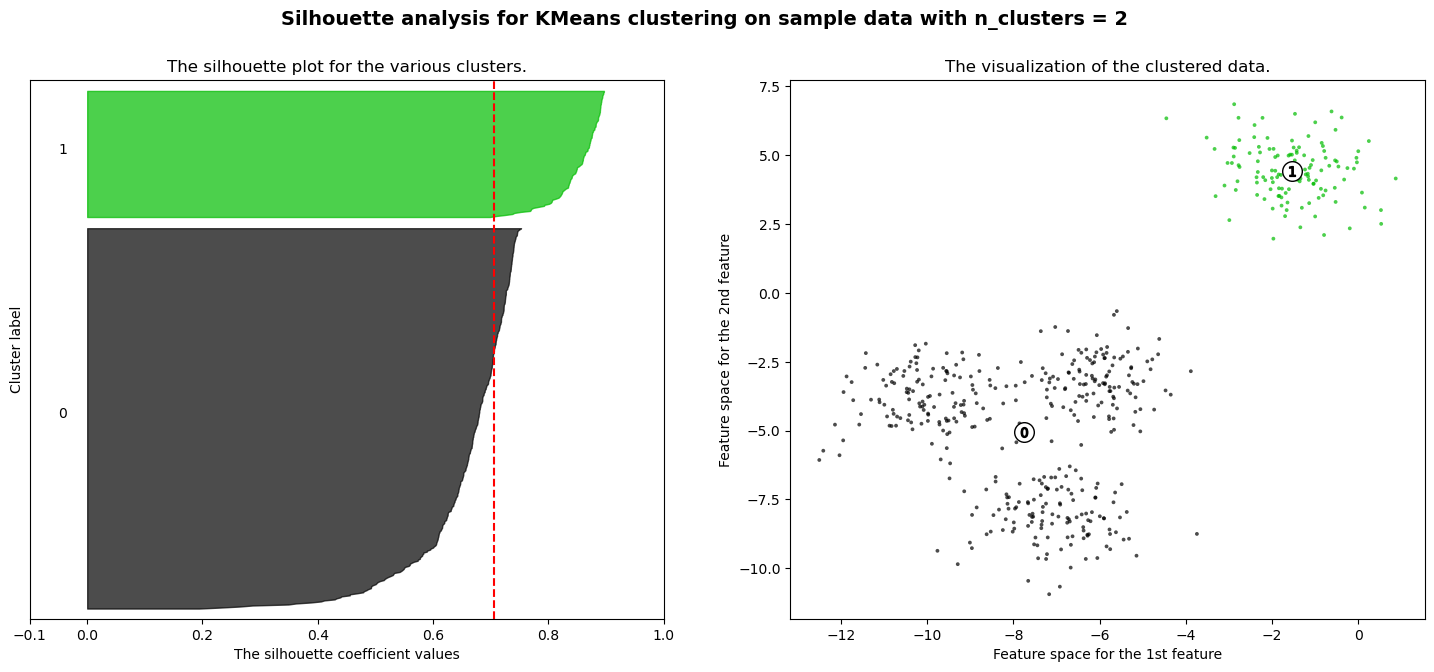

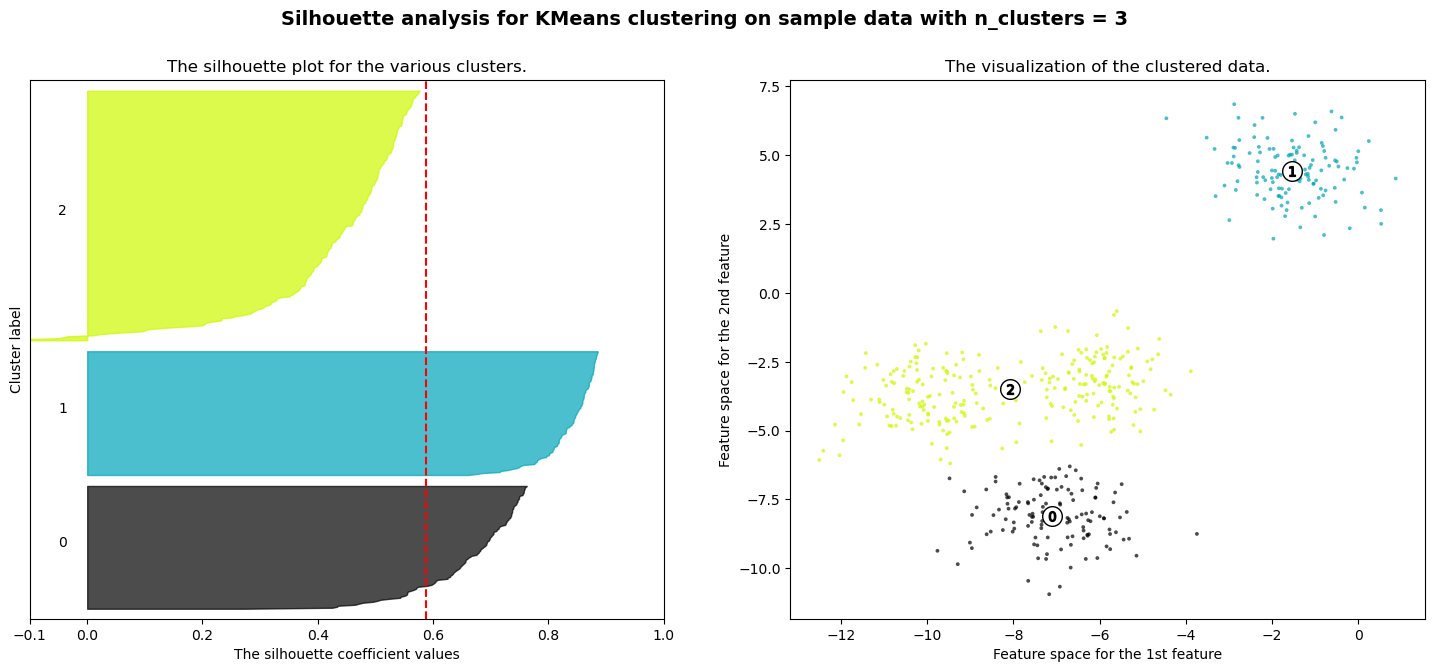

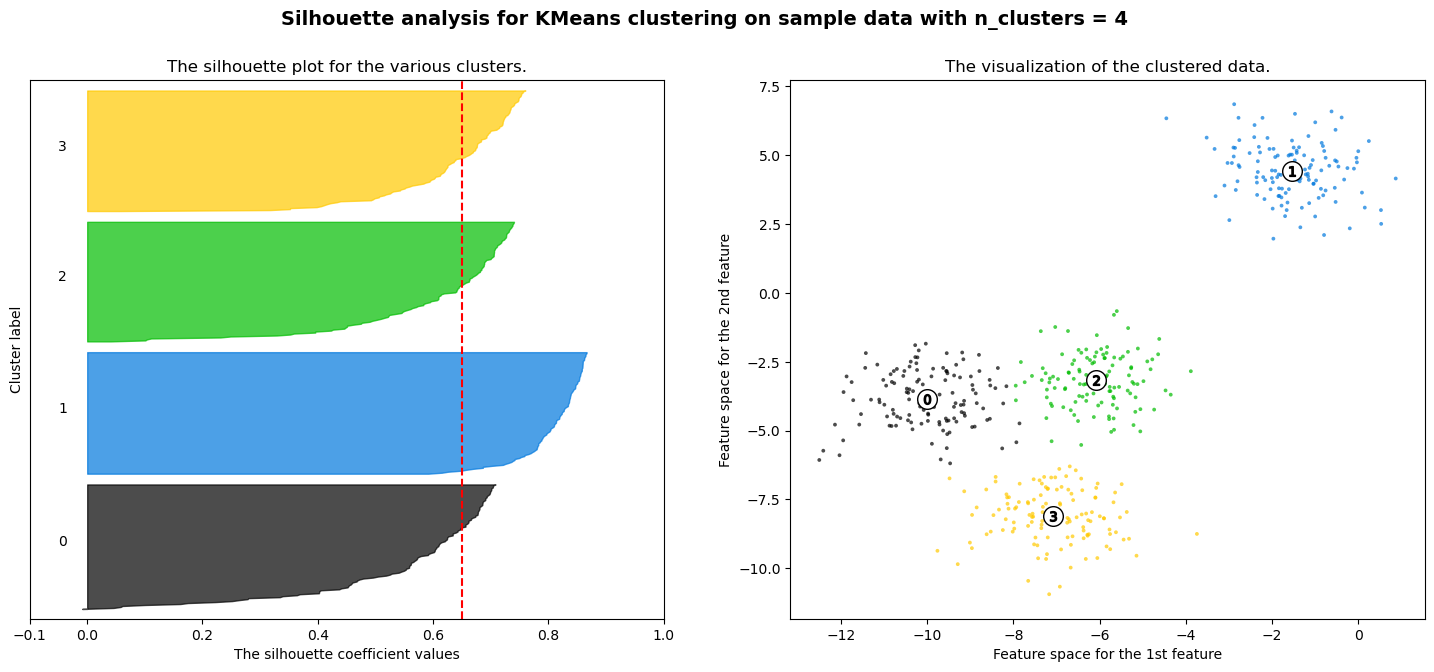

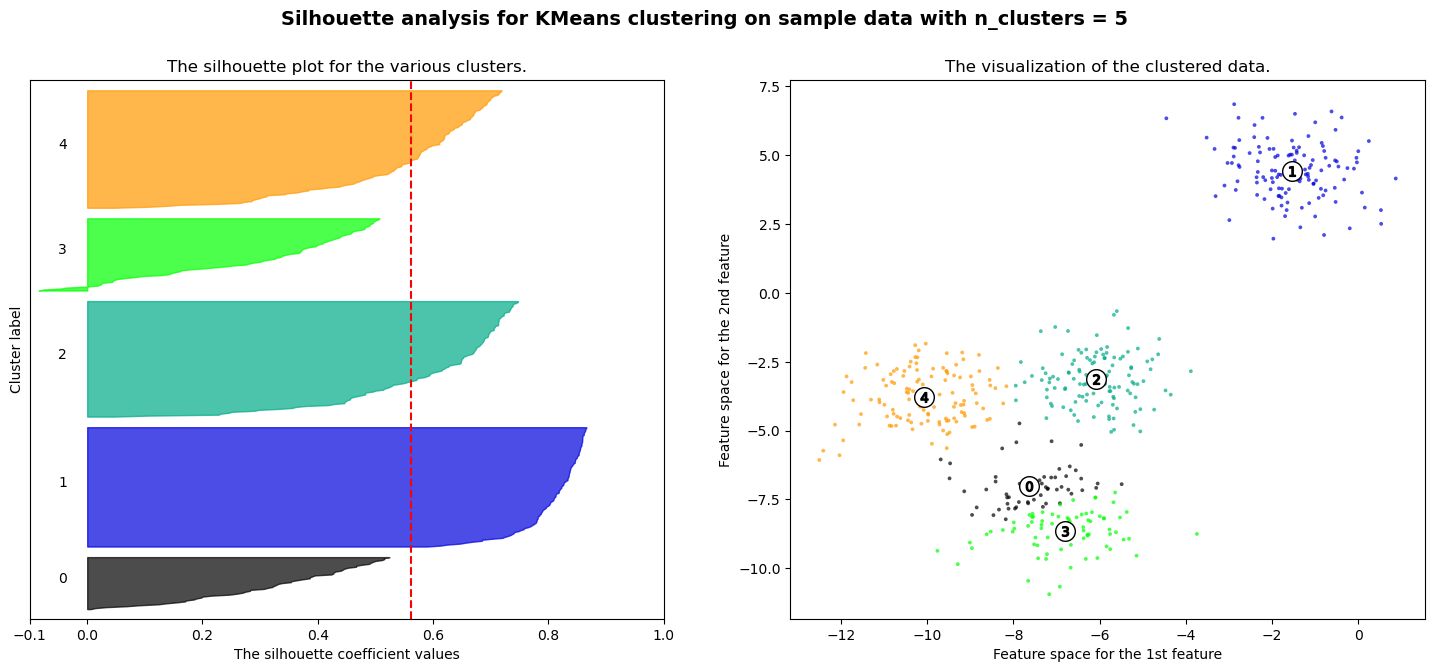

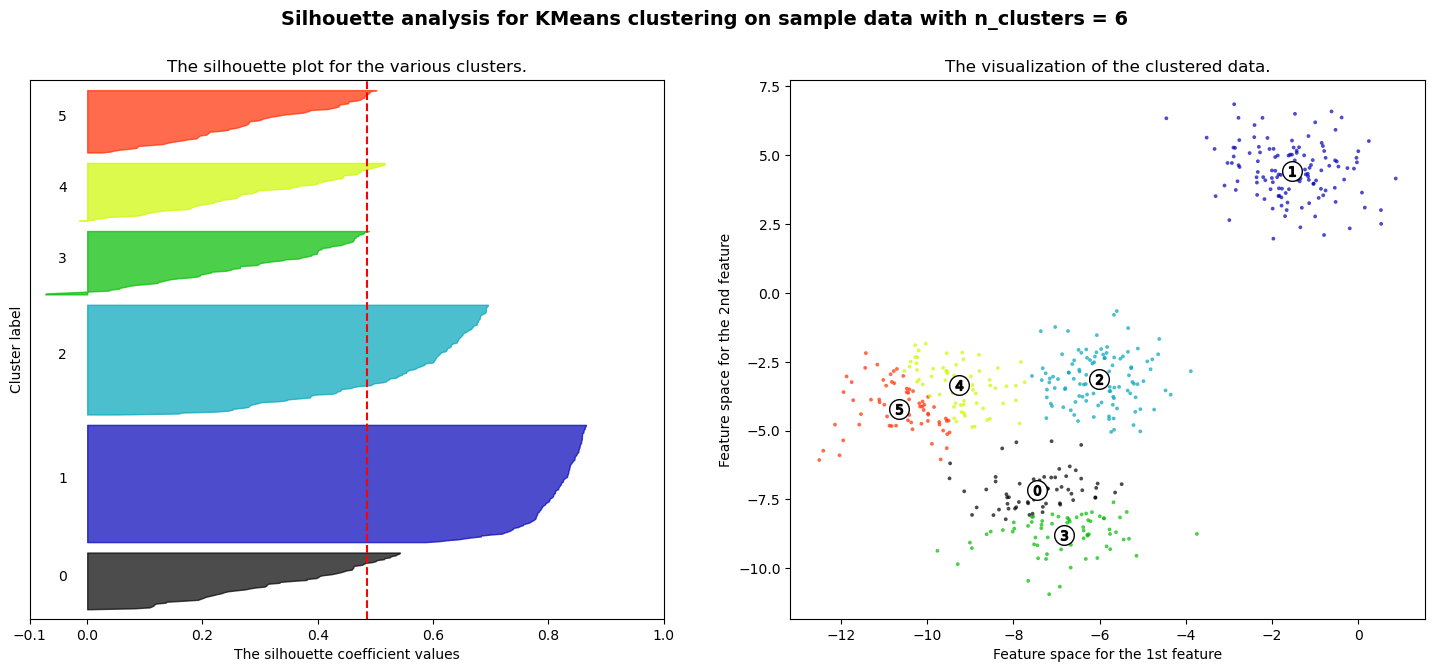

In [14]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()